In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


### Importação das bases

In [2]:
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

Entendendo os dados

In [4]:
sample.isna().sum()
test.isna().sum()
train.isna().sum()
## Não possui valores nulos

policy_id                           0
policy_tenure                       0
age_of_car                          0
age_of_policyholder                 0
area_cluster                        0
population_density                  0
make                                0
segment                             0
model                               0
fuel_type                           0
max_torque                          0
max_power                           0
engine_type                         0
airbags                             0
is_esc                              0
is_adjustable_steering              0
is_tpms                             0
is_parking_sensors                  0
is_parking_camera                   0
rear_brakes_type                    0
displacement                        0
cylinder                            0
transmission_type                   0
gear_box                            0
steering_type                       0
turning_radius                      0
length      

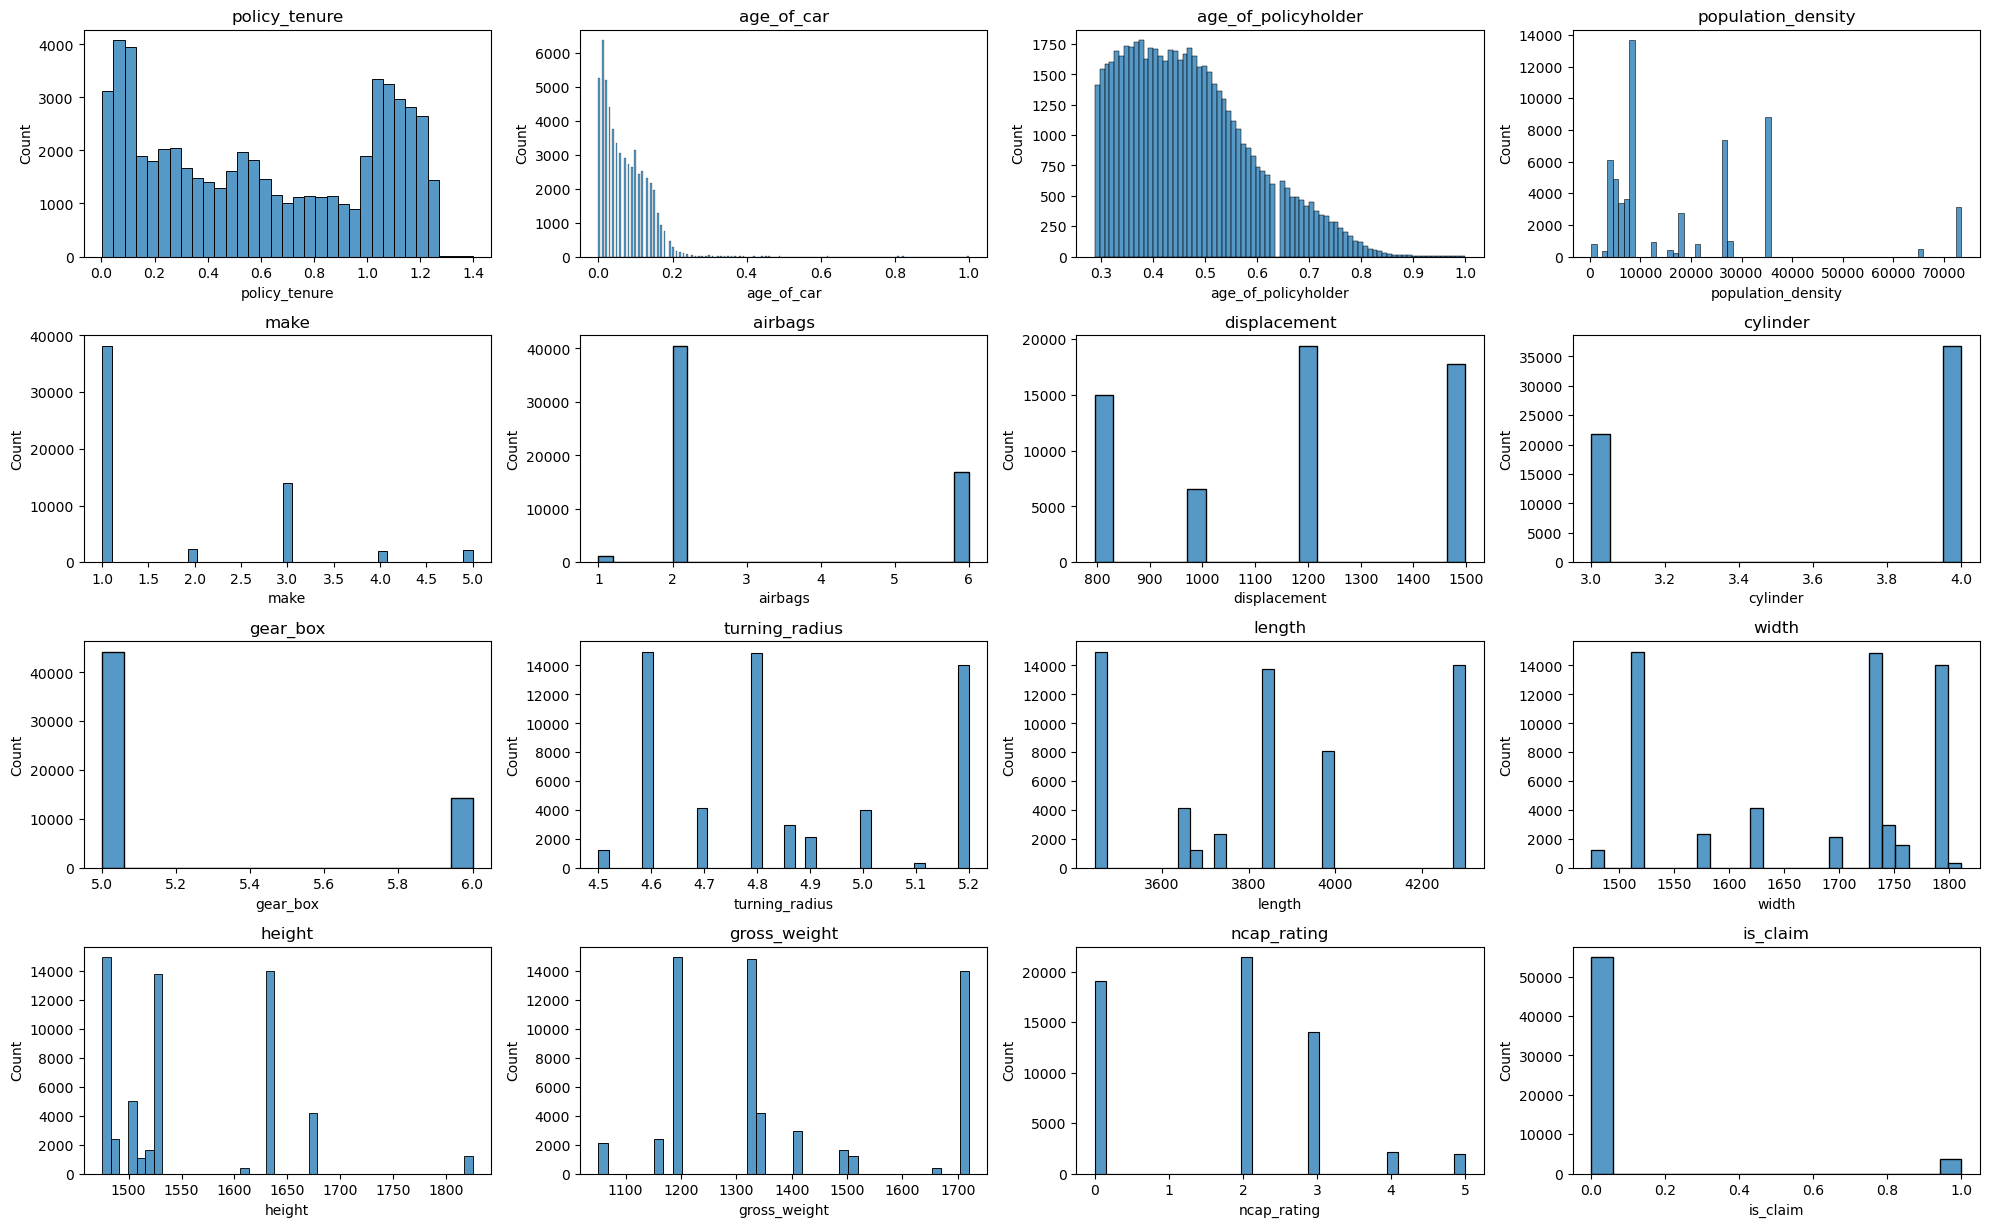

In [5]:
numeric_columns_train = train.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(20, 15))

for i, column in enumerate(numeric_columns_train.columns):
    plt.subplot(5, 4, i + 1)
    sns.histplot(train[column], kde=False)
    plt.title(column)
    plt.tight_layout()

plt.show()


In [6]:
menor_dois_meses = train['age_of_car'] <= 0.2
porcentagem_menor_dois_meses = menor_dois_meses.sum()/train['age_of_car'].count()
round(porcentagem_menor_dois_meses,2)

0.99

In [6]:
dois_airbag = train['airbags'] == 2
porcentagem_dois_airbag = dois_airbag.sum()/train['airbags'].count()
round(porcentagem_dois_airbag,2)

0.69

In [52]:
ncap_5_or_4 = (train['ncap_rating'] == 5) | (train['ncap_rating'] == 4)
porcentagem_ncap_5_or_4 = ncap_5_or_4.sum()/train['ncap_rating'].count()
round(porcentagem_ncap_5_or_4,2)

0.07

#### Informações do histograma:

Policy Tenure: A maior parte dos seguros ficou vigente por apenas 1 mês

Age of Car: A maior parte das pessoas optaram por fazer o seguro assim que compraram o carro (99%). 

AirBags: A maioria dos carros possuem 2 aribags (69%).

ncap: Apenas 7% dos carros possuem o rating de segurança ncap sendo 4 ou 5.

A ideia do próximo gráfico foi tirada do Zubin Relia (Kaggle), alterei as colunas de interesse.

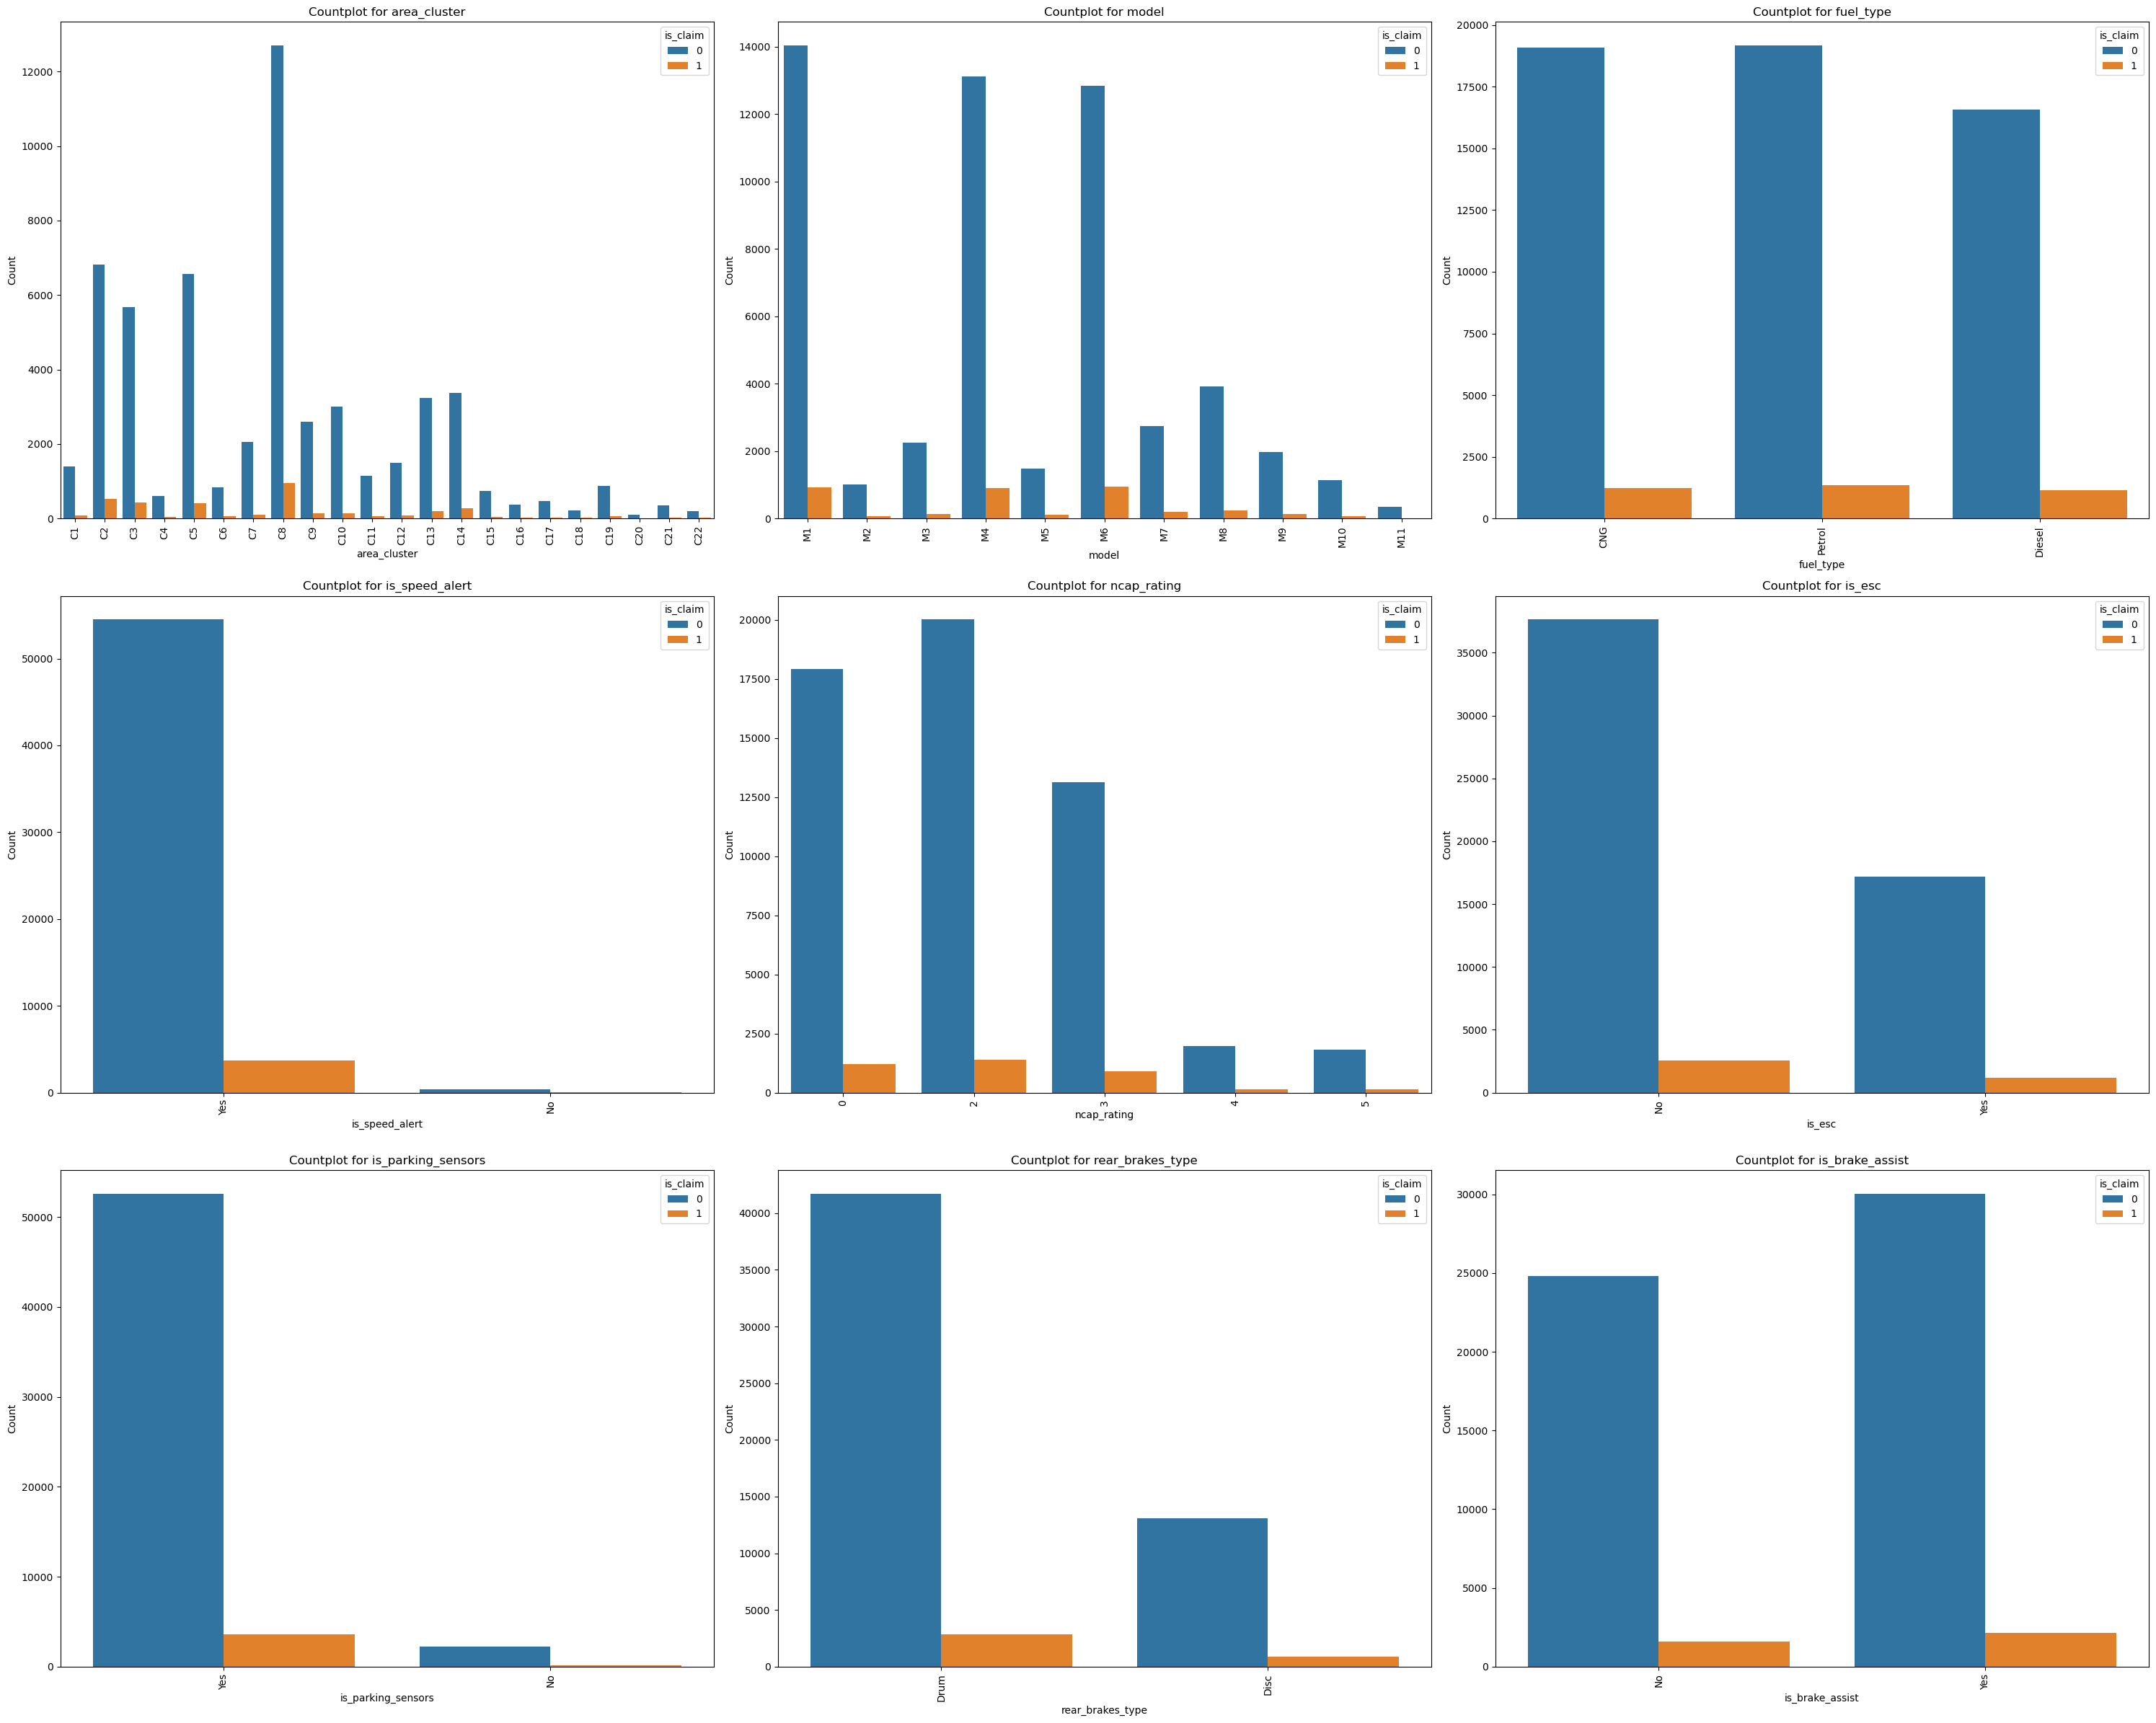

In [54]:
### Chart by Zubin Relia (From Kaggle)

fig, axes = plt.subplots(3,3, figsize=(30,24))
axes = axes.flatten()

cols_1=['area_cluster', 'model', 'fuel_type', 'is_speed_alert', 'ncap_rating', 'is_esc', 'is_parking_sensors', 'rear_brakes_type', 'is_brake_assist']

for i, column in enumerate(cols_1):
    ax = axes[i]  # Select the current subplot

    # Plot the countplot
    sns.countplot(data=train, x=column, ax=ax, hue='is_claim')
    ax.set_title(f'Countplot for {column}')
    
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels if need
    
    
# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [40]:
total_claim = train[train["is_claim"] == 1]

In [41]:
ncap_5_or_4_and_claim = ((train['ncap_rating'] == 5) | (train['ncap_rating'] == 4)) & (train['is_claim'] == 1)
porcentagem_ncap_5_or_4_and_claim = ncap_5_or_4_and_claim.sum()/total_claim["ncap_rating"].count().sum()
round(porcentagem_ncap_5_or_4_and_claim,2)

0.07

In [53]:
ncap_0_to_3_and_claim = ((train['ncap_rating'] == 0) | (train['ncap_rating'] == 1) | (train['ncap_rating'] == 2) | (train['ncap_rating'] == 3)) & (train['is_claim'] == 1)
total_claim = train[train["is_claim"] == 1]
porcentagem_ncap_0_to_3_and_claim = ncap_0_to_3_and_claim.sum()/total_claim["ncap_rating"].count().sum()
round(porcentagem_ncap_0_to_3_and_claim,2)

0.93

In [63]:
drum_brakes_and_claim = train[(train['rear_brakes_type'] == 'Drum') & (train['is_claim'] == 1)]
porcentagem_drum_brakes = len(drum_brakes_and_claim) / total_claim['rear_brakes_type'].count()
round(porcentagem_drum_brakes, 2)


0.76

In [66]:
drum_brakes_tot = len(train[train['rear_brakes_type'] == 'Drum']) / train['rear_brakes_type'].count()
round(drum_brakes_tot, 2)

0.76

Os carros com Ncap entre 0 e 3 representam 93% de todos os carros. E também representam 93% dos carros que utilizaram o seguro.

Existem dois tipos de freios, os freios Drum e os Disc, 76% dos seguros que foram utilizados estavam utilizando os freios Drum. Era esperado uma porcentagem maior pois os no total os freios Drum representam também 76% do total dos freios, o que é uma coincidência.

In [85]:
train['c2'] = train['area_cluster'].apply(lambda x: 1 if x == 'C2' else 0)
train['c3'] = train['area_cluster'].apply(lambda x: 1 if x == 'C3' else 0)
train['c5'] = train['area_cluster'].apply(lambda x: 1 if x == 'C5' else 0)
train['c8'] = train['area_cluster'].apply(lambda x: 1 if x == 'C8' else 0)


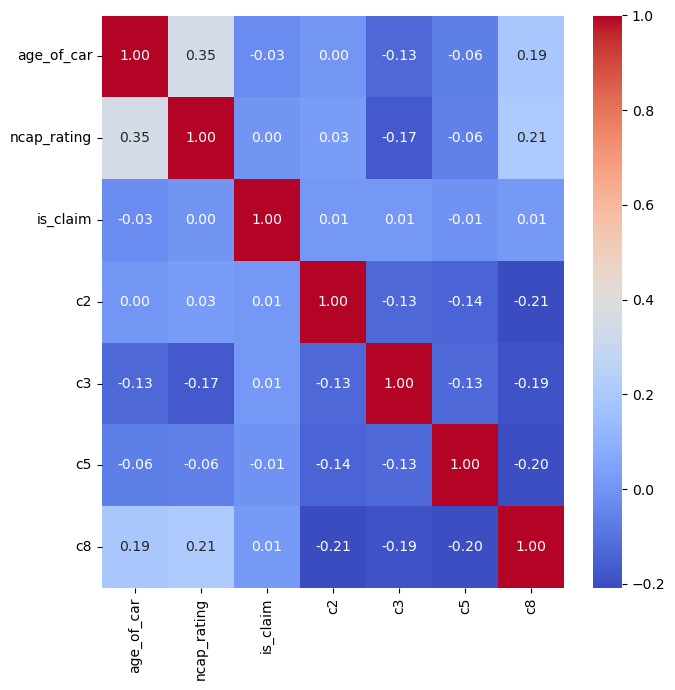

In [94]:
vehicle_features = ['age_of_car', 'ncap_rating', 'is_claim', 'c2','c3','c5','c8']
vehicle_df = train[vehicle_features]
fig, axes = plt.subplots(figsize=(7, 7))
sns.heatmap(vehicle_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", )
plt.tight_layout()
plt.show()



ML

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
train = pd.read_csv('train.csv') 
train_no_claims = pd.read_csv('train.csv')
train_no_claims = train_no_claims.drop('is_claim', axis=1)

In [14]:
features = train_no_claims.select_dtypes(include=['float64', 'int64'])
target = train['is_claim']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state= 42)
model = LogisticRegression(class_weight='balanced')
#class_weight='balanced'
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))


[[2155 3326]
 [ 134  245]]
              precision    recall  f1-score   support

           0       0.94      0.39      0.55      5481
           1       0.07      0.65      0.12       379

    accuracy                           0.41      5860
   macro avg       0.51      0.52      0.34      5860
weighted avg       0.89      0.41      0.53      5860



In [13]:
test_features = test.select_dtypes(include=['float64', 'int64'])
test_predictions = model.predict(test_features)
test['is_claim'] = test_predictions
test.to_csv('testans.csv', index=False)
